In [143]:
# Imports, as always...
import pandas as pd
import numpy as np
from pathlib import Path
import os
import ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

import image_keyword_features
import create_data

import warnings
warnings.filterwarnings('ignore')

---

---

# Updates to RQ1

Testing has shown that there is not much to be learnt from the perceived sentiment of listing images...

In [144]:
data = image_keyword_features.compute_image_sentiments('datasets/image_keywords_edinburgh.csv')

In [145]:
data.sample(5)

id  mean_sentiment  std_sentiment  extraction_count
724   1.435701e+07       -0.000911       0.005314              35.0
4288  6.688364e+17        0.000000       0.000000              18.0
3212  5.243015e+07       -0.003959       0.016640              36.0
3702  6.120771e+17        0.000000       0.000000              43.0
2933  4.978837e+07       -0.002041       0.009560              43.0

In [146]:
data.describe()

id  mean_sentiment  std_sentiment  extraction_count
count  5.126000e+03     5126.000000    5126.000000       5126.000000
mean   2.104933e+17        0.000508       0.009166         36.997269
std    3.111559e+17        0.003506       0.016253         14.291379
min    2.428800e+04       -0.024214       0.000000          3.000000
25%    2.186357e+07       -0.000541       0.000000         26.000000
50%    4.128565e+07        0.000000       0.000000         36.000000
75%    6.252139e+17        0.000000       0.012170         46.750000
max    7.825218e+17        0.046885       0.159758         99.000000

Looking into associated scores of keywords...

In [147]:
success = pd.read_csv('datasets/master_edinburgh.csv')[['id', 'success_score']]

In [148]:
keywords = create_data.mean_keyword_scores(success, 'datasets/image_keywords_edinburgh.csv')

# Sort the keywords by their associated scores.
keywords = sorted(keywords.items(), key=lambda x:x[1], reverse=True)

In [149]:
keywords[:5]

[('Bowling', 4.364582472793483),
 ('Violin', 4.125347851705533),
 ('Marching', 3.1442773493737404),
 ('Group Performance', 3.0193851666171887),
 ('Snake', 2.9552190196823758)]

---

# Updates to RQ2

---

# Updates to RQ3

---

# Miscellaneous Fun

## Data Preprocessing: Cleaning and Selecting

In [150]:
# Create master data for Edinburgh (if not created already).
if not Path('datasets/master_edinburgh.csv').is_file():
    create_data.city_data_generation('edinburgh', 'datasets', datetime(2022, 12, 16), True)
    print('Master data file generated.')

else:
    print('Pre-existing master data file found (no new data created).')

# Note: This takes around 3 minutes on my laptop for ~7500 listings and ~500000 reviews (Edinburgh).

Pre-existing master data file found (no new data created).


In [151]:
# Get the master data.
master_data = pd.read_csv('datasets/master_edinburgh.csv').iloc[:,2:]

In [152]:
# We will be predicting success o, it would only be fair for us to remove all data used to generate success scores.
master_data.drop(columns=[
    'price', 
    'minimum_nights_avg_ntm', 
    'number_of_reviews_ltm', 
    'review_scores_rating'
], inplace=True, axis=1)

# It would also be in the spirit of things to remove other review scores (e.g. for cleanliness), as that is sort of cheating.
master_data.drop(columns=[
    'review_scores_accuracy', 
    'review_scores_cleanliness',
    'review_scores_checkin', 
    'review_scores_communication',
    'review_scores_location', 
    'review_scores_value'
], inplace=True, axis=1)

In [153]:
# Count the number of missing values in each feature.
missing_values = master_data.isna().sum().sort_values(ascending=False)
missing_values

neighbourhood_group_cleansed    7389
bathrooms                       7389
license                         7374
host_neighbourhood              4382
host_about_keywords             3344
                                ... 
host_id                            0
availability_30                    0
availability_60                    0
availability_90                    0
has_availability                   0
Length: 67, dtype: int64

In [154]:
# Drop features with majority missing values.
threshold = master_data.shape[0] // 2
master_data.drop(columns=missing_values[missing_values > threshold].index, inplace=True, axis=1)
print('dropped:', missing_values[missing_values > threshold].index)

dropped: Index(['neighbourhood_group_cleansed', 'bathrooms', 'license',
       'host_neighbourhood'],
      dtype='object')


In [155]:
# Drop rows with missing a succuess score.
print('Number of dropped rows (no success score):', len(master_data[master_data.success_score.isna()]))
master_data = master_data[master_data.success_score.notna()]

Number of dropped rows (no success score): 669


In [156]:
# Remove unhelpful features (for prediction of success).
master_data.drop(columns=[
    'host_id',
    'neighbourhood',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'bathrooms_text',
    'amenities',
    'minimum_minimum_nights', 
    'maximum_minimum_nights',
    'minimum_maximum_nights', 
    'maximum_maximum_nights',
    'maximum_nights_avg_ntm',
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'title_keywords',
    'description_keywords', 
    'neighborhood_overview_keywords',
    'host_about_keywords'
], inplace=True, axis=1) 

# Remove features that almost certinaly don't add anything (e.g. almost all the same value).
master_data.drop(columns=[
    'has_availability',
    'host_has_profile_pic'
], inplace=True, axis=1)

In [157]:
# Helper function for converting dates to days since.
def elapsed_days(from_date_as_string, to_date=datetime(2022, 12, 16)):
    from_date = datetime.strptime(from_date_as_string, '%Y-%m-%d')
    return max(0, (to_date - from_date).days)

In [158]:
# Convert pseudonumeric types (e.g. dates) to numeric...

master_data.host_since = master_data.host_since.apply(elapsed_days)

master_data.host_response_rate = master_data.host_response_rate.apply(
    lambda x : float(x[:-1]) if not pd.isna(x) 
    else x
)

master_data.host_acceptance_rate = master_data.host_acceptance_rate.apply(
    lambda x : float(x[:-1]) if not pd.isna(x) 
    else x
)

master_data.host_verifications = master_data.host_verifications.apply(
    lambda x : len(x)
)

master_data.first_review = master_data.first_review.apply(
    lambda x : elapsed_days(x) if not pd.isna(x)
    else x
)

master_data.last_review = master_data.last_review.apply(
    lambda x : elapsed_days(x) if not pd.isna(x)
    else x
)

In [159]:
# Another look at missing data.
master_data.isna().sum().sort_values(ascending=False)

host_about_polarity                   2679
host_about_subjectivity               2679
images_confidences                    2091
images_keywords                       2091
neighborhood_overview_polarity        1824
neighborhood_overview_subjectivity    1824
host_response_time                    1313
host_response_rate                    1313
host_acceptance_rate                   591
bedrooms                               103
beds                                    59
description_subjectivity                52
description_polarity                    52
min_review_sentiment                     1
max_review_sentiment                     1
perceived_review_sentiment               1
reviews_per_month                        0
title_polarity                           0
id                                       0
title_subjectivity                       0
last_review                              0
instant_bookable                         0
number_of_reviews                        0
first_revie

In [160]:
# Replace missing polarity and subjectivity scores with 0 (i.e. neutral and factual).
master_data.host_about_polarity = master_data.host_about_polarity.fillna(0)
master_data.host_about_subjectivity = master_data.host_about_subjectivity.fillna(0)
master_data.neighborhood_overview_polarity = master_data.neighborhood_overview_polarity.fillna(0)
master_data.neighborhood_overview_subjectivity = master_data.neighborhood_overview_subjectivity.fillna(0)
master_data.description_polarity = master_data.description_polarity.fillna(0)
master_data.description_subjectivity = master_data.description_subjectivity.fillna(0)

# Replace missing host_response_rate, host_acceptance_rate with mean values.
master_data.host_response_rate = master_data.host_response_rate.fillna(master_data.host_response_rate.mean())
master_data.host_acceptance_rate = master_data.host_acceptance_rate.fillna(master_data.host_acceptance_rate.mean()) 

# Replace missing host_response_time with mode values.
master_data.host_response_time = master_data.host_response_time.fillna(master_data.host_response_time.mode().values[0])

In [161]:
# Remove all rows with missing values still remaining.
master_data = master_data.dropna()

In [162]:
# So what are we now working with?
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4524 entries, 1 to 7388
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  4524 non-null   int64  
 1   host_since                          4524 non-null   int64  
 2   host_response_time                  4524 non-null   object 
 3   host_response_rate                  4524 non-null   float64
 4   host_acceptance_rate                4524 non-null   float64
 5   host_is_superhost                   4524 non-null   object 
 6   host_listings_count                 4524 non-null   int64  
 7   host_total_listings_count           4524 non-null   int64  
 8   host_verifications                  4524 non-null   int64  
 9   host_identity_verified              4524 non-null   object 
 10  room_type                           4524 non-null   object 
 11  accommodates                        4524 no

In [163]:
# Calculate the skewness of the features.
skewness = master_data.skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 1])

# Don't worry about skewness with the success scores or id.
skewness.success_score = 0
skewness.id = 0

minimum_nights               22.003614
host_total_listings_count    13.867522
host_listings_count          12.095707
beds                          4.761649
last_review                   3.515740
number_of_reviews_l30d        3.422894
number_of_reviews             2.906509
bedrooms                      1.945824
reviews_per_month             1.881866
accommodates                  1.664764
success_score                 1.649893
host_verifications            1.146201
min_review_sentiment         -1.068994
max_review_sentiment         -1.242397
host_acceptance_rate         -3.414334
host_response_rate           -6.679898
dtype: float64


In [164]:
# Deal with positive skewness by performing a square root transformation.
for skew_feature in skewness[skewness > 1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 1/2)

# Deal with negative skewness by performing a square transformation.
for skew_feature in skewness[skewness < -1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 2)

In [165]:
# Re-assess skewness.
skewness = master_data.skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 1])

# Don't worry about skewness with the success scores.
skewness.success_score = 0
skewness.id = 0

minimum_nights               12.363368
host_total_listings_count     6.125455
host_listings_count           5.847414
last_review                   2.126666
beds                          1.689425
success_score                 1.649893
number_of_reviews             1.224579
bedrooms                      1.212068
host_verifications            1.146201
min_review_sentiment         -1.068994
max_review_sentiment         -1.242397
host_acceptance_rate         -2.259521
host_response_rate           -4.813385
dtype: float64


In [166]:
# Deal with positive skewness AGAIN by performing a square root transformation AGAIN (i.e. fourth root).
for skew_feature in skewness[skewness > 1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 1/2)

# Deal with negative skewness AGAIN by performing a square transformation AGAIN (i.e. to power 4).
for skew_feature in skewness[skewness < -1.5].index:
    master_data[skew_feature] = np.power(master_data[skew_feature], 2)

In [167]:
# Re-assess skewness.
skewness = master_data.skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 1])

# Don't worry about skewness with the success scores.
skewness.success_score = 0

minimum_nights               6.480632
host_total_listings_count    3.230643
host_listings_count          3.077775
success_score                1.649893
last_review                  1.308695
number_of_reviews            1.224579
bedrooms                     1.212068
host_verifications           1.146201
beds                         1.063829
min_review_sentiment        -1.068994
max_review_sentiment        -1.242397
host_acceptance_rate        -1.502282
host_response_rate          -3.430244
dtype: float64


In [168]:
# Convert categorical (e.g. boolean) types to numeric...

master_data.host_response_time = master_data.host_response_time.map(
    lambda x : {'within an hour' : 1, 'within a few hours' : 2, 'within a day' : 3, 'a few days or more' : 4}.get(x, 0)
)

master_data.host_is_superhost = master_data.host_is_superhost.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

master_data.host_identity_verified = master_data.host_identity_verified.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

master_data.room_type = master_data.room_type.map(
    lambda x : {'Entire home/apt' : 1, 'Private room' : 2, 'Hotel room' : 3, 'Shared room' : 4}.get(x, 0)
)

master_data.instant_bookable = master_data.instant_bookable.map(
    lambda x : {'t' : 1, 'f' : 0}.get(x, 0)
)

<AxesSubplot: >

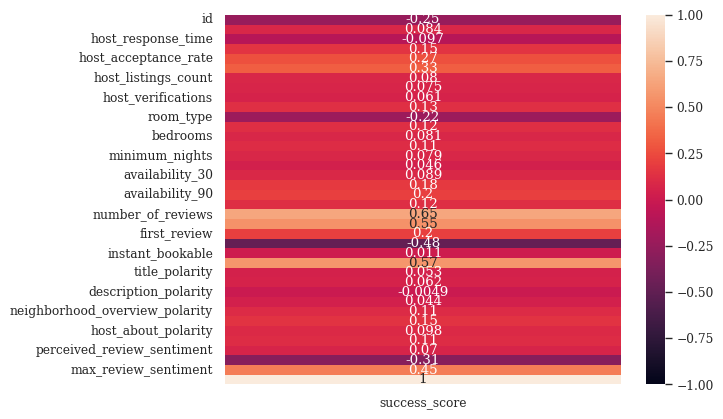

In [169]:
# Show the correlations with success.
corr = master_data.corr()[['success_score']]
sns.heatmap(corr, annot=True, vmin=-1, vmax=1)

## Data Preprocessing: Creating New Features

From the mean scores of each image keyword, come up with an average scoring of the extracted keywords for each listing. That is, from the calculated success scores of each extracted image keywords, calcualted the perceived success in the images.

We will weight this average using the confidence scores (e.g. if we are 87% confident in the keyword "window", and "window" has an average score of 1.0, then the contribution of "window" to the perceived image score of all listings it appears in is 1.0 * 0.87 = 0.87).

In [170]:
# Calcualte the success of the image keywords.
keyword_success = create_data.mean_keyword_scores(master_data[['id', 'success_score']], 'datasets/image_keywords_edinburgh.csv')

In [171]:
# For each listing, compute the mean and standard deviation in the perceived success of image keywords.
weighted_image_score_mean = []
weighted_image_score_max = []
weighted_image_score_min = []
weighted_image_score_std = []

for i in range(len(master_data.index)):
    entry = master_data.iloc[i]

    keywords = ast.literal_eval(entry.images_keywords)
    confidences = ast.literal_eval(entry.images_confidences)

    scores = []
    for j in range(len(keywords)):
        scores.append(keyword_success[keywords[j]] * (confidences[j] / 100)) 

    weighted_image_score_mean.append(np.mean(scores))
    weighted_image_score_max.append(max(scores))
    weighted_image_score_min.append(min(scores))
    weighted_image_score_std.append(np.std(scores))

master_data['weighted_image_score_mean'] = weighted_image_score_mean
master_data['weighted_image_score_max'] = weighted_image_score_max
master_data['weighted_image_score_min'] = weighted_image_score_min
master_data['weighted_image_score_std'] = weighted_image_score_std

In [172]:
# Tell us a bit about them.
master_data[['weighted_image_score_mean', 'weighted_image_score_max', 'weighted_image_score_min', 'weighted_image_score_std']].describe()

weighted_image_score_mean  weighted_image_score_max  \
count                4524.000000               4524.000000   
mean                    0.588386                  0.852211   
std                     0.047623                  0.121360   
min                     0.414123                  0.629933   
25%                     0.555851                  0.812841   
50%                     0.588495                  0.829140   
75%                     0.620178                  0.833916   
max                     0.801407                  4.291716   

       weighted_image_score_min  weighted_image_score_std  
count               4524.000000               4524.000000  
mean                   0.268064                  0.173013  
std                    0.070787                  0.022676  
min                    0.000000                  0.047063  
25%                    0.241134                  0.160882  
50%                    0.280054                  0.173308  
75%                    0.309758                  0.184575  
max                    0.610748                  0.569920

We would like to compare successful listings with unsuccessful listings. So let's split the data into listings that are more successful than average and listings that are less successful than average.

In [173]:
# Create better_than_average feature
master_data['better_than_average'] = master_data.success_score > np.mean(master_data.success_score)

## Having a Wee Explore

In [174]:
# Beautification.
sns.set_style('darkgrid')
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper')
sns.set_palette('Set2')

Investigating differences between the distribution of features between more and less successful listings.

### Weighted Image Score

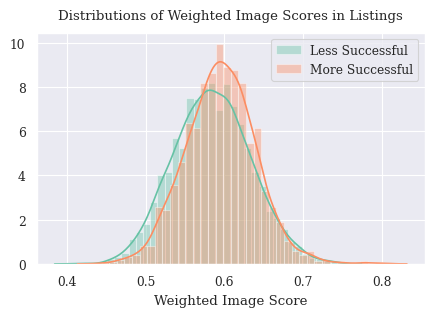

In [175]:
fig, ax = plt.subplots(figsize=(5, 3))

less_sample = master_data[master_data.better_than_average == False].weighted_image_score_mean
more_sample = master_data[master_data.better_than_average == True].weighted_image_score_mean

sns.distplot(less_sample, 
             ax=ax, label='Less Successful')
sns.distplot(more_sample, 
             ax=ax, label='More Successful')

ax.legend()
ax.set_title("Distributions of Weighted Image Scores in Listings", pad=10)
ax.set_ylabel("")
ax.set_xlabel("Weighted Image Score")

fig.savefig('figures/weighted_image_scores_disctribution_comparison.pdf', 
            dpi=300, format='pdf', bbox_inches='tight', facecolor='white')

In [176]:
print("Number of more successful listings:", len(more_sample))
print("Number of less successful listings:", len(less_sample))
print("Hence, total:", len(more_sample) + len(less_sample))

Number of more successful listings: 1572
Number of less successful listings: 2952
Hence, total: 4524


Performing the two-sample one-tailed student's t-test to find whether the mean of the *more* distrubtion is greater than the mean of the *less* distribution...

In [177]:
sig_level = 0.01

_, double_p = ttest_ind(more_sample, less_sample, equal_var=False)

if np.mean(more_sample) > np.mean(less_sample):
    p_value = double_p / 2

else:
    p_value = 1 - (double_p / 2)

print("p-value for the two-sample one-tailed student's t-test:", p_value)

if p_value < sig_level:
    print("Hence, we can reject the null hypothesis (that the means are equal).")

else:
    print("Hence, we cannot reject the null hypothesis (that the means are equal)")

p-value for the two-sample one-tailed student's t-test: 2.4238139746717884e-13
Hence, we can reject the null hypothesis (that the means are equal).


What are the most successful keywords?

In [178]:
# Most successful keywords by their associated listings' success scores.
keyword_scores = create_data.mean_keyword_scores(master_data, 'datasets/image_keywords_edinburgh.csv')

# Sort the keywords by their associated scores.
keyword_scores = sorted(keyword_scores.items(), key=lambda x:x[1], reverse=True)

print('highest scoring keywords:', keyword_scores[:5])

highest scoring keywords: [('Bowling', 4.364582472793483), ('Violin', 4.125347851705533), ('Marching', 3.1442773493737404), ('Group Performance', 3.0193851666171887), ('Snake', 2.9552190196823758)]


What are the most and least common keywords?

In [179]:
# Counting keyword occurences.
keyword_counts = create_data.count_keyword_occurences('datasets/image_keywords_edinburgh.csv')

# Sort the keywords by their weighted occurences.
keyword_counts = sorted(keyword_counts.items(), key=lambda x:x[1][1], reverse=True)

print('Most common keywords:', keyword_counts[:5])
print('Least common keywords:', keyword_counts[-5:])

Most common keywords: [('Indoors', (4887, 4755.078845405593)), ('Furniture', (4840, 4695.3731059646725)), ('Interior Design', (4790, 4500.306217842108)), ('Room', (4704, 4376.939095115667)), ('Home Decor', (4562, 4193.024990425107))]
Least common keywords: [('Bikini', (1, 0.5502965927124024)), ('Orange Juice', (1, 0.5502677536010743)), ('Reading', (1, 0.550234603881836)), ('Driving License', (1, 0.5501981353759766)), ('Palette', (1, 0.5500713729858399))]


What is the scoring rate of keywords?

In [180]:
keyword_scoring_rates = {}

# Compute the scoring rates.
for i in range(len(keyword_scores)):
    score = keyword_scores[i][1]
    count = keyword_counts[i][1][0]

    # Scoring rate is defined by the ratio between the mean score and the count.
    keyword_scoring_rates[keyword_scores[i][0]] = score / count

# Sort the keywords by their scoring rate.
keyword_scoring_rates = sorted(keyword_scoring_rates.items(), key=lambda x:x[1], reverse=True)

print('Highest scoring rate keywords:', keyword_scoring_rates[:5])
print('Lowest scoring rate keywords:', keyword_scoring_rates[-5:])

Highest scoring rate keywords: [('Swamp', 0.3088114955272392), ('Gardening', 0.3071480817141858), ('Marina', 0.3063044428591727), ('Tile Roof', 0.305475940312899), ('Jacket', 0.3047692306715215)]
Lowest scoring rate keywords: [('Sneaker', 0.0), ('Tunnel', 0.0), ('Drying Rack', 0.0), ('Harp', 0.0), ('Bamboo', 0.0)]


### Perceived Review Sentiment

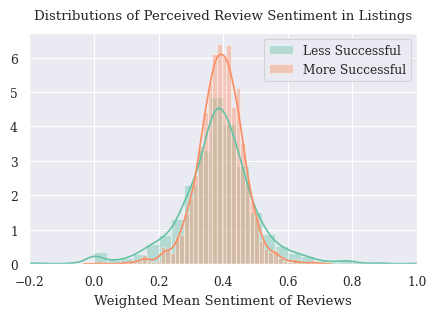

In [181]:
fig, ax = plt.subplots(figsize=(5, 3))

less_sample = master_data[master_data.better_than_average == False].perceived_review_sentiment
more_sample = master_data[master_data.better_than_average == True].perceived_review_sentiment

sns.distplot(less_sample, 
             ax=ax, label='Less Successful')
sns.distplot(more_sample, 
             ax=ax, label='More Successful')

ax.legend()
ax.set_title("Distributions of Perceived Review Sentiment in Listings", pad=10)
ax.set_ylabel("")
ax.set_xlabel("Weighted Mean Sentiment of Reviews")

ax.set_xlim(-.2,1)

fig.savefig('figures/perceived_review_sentiment_disctribution_comparison.pdf', 
            dpi=300, format='pdf', bbox_inches='tight', facecolor='white')

In [182]:
sig_level = 0.01

_, double_p = ttest_ind(more_sample, less_sample, equal_var=False)

if np.mean(more_sample) > np.mean(less_sample):
    p_value = double_p / 2

else:
    p_value = 1 - (double_p / 2)

print("p-value for the two-sample one-tailed student's t-test:", p_value)

if p_value < sig_level:
    print("Hence, we can reject the null hypothesis (that the means are equal).")

else:
    print("Hence, we cannot reject the null hypothesis (that the means are equal)")

p-value for the two-sample one-tailed student's t-test: 9.545066713647278e-05
Hence, we can reject the null hypothesis (that the means are equal).


### Review Frequency and Recency

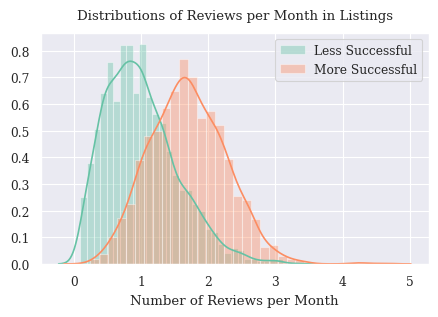

In [183]:
fig, ax = plt.subplots(figsize=(5, 3))

less_sample = master_data[master_data.better_than_average == False].reviews_per_month
more_sample = master_data[master_data.better_than_average == True].reviews_per_month

sns.distplot(less_sample, 
             ax=ax, label='Less Successful')
sns.distplot(more_sample, 
             ax=ax, label='More Successful')

ax.legend()
ax.set_title("Distributions of Reviews per Month in Listings", pad=10)
ax.set_ylabel("")
ax.set_xlabel("Number of Reviews per Month")

fig.savefig('figures/reviews_per_month_disctribution_comparison.pdf', 
            dpi=300, format='pdf', bbox_inches='tight', facecolor='white')

In [184]:
sig_level = 0.01

_, double_p = ttest_ind(more_sample, less_sample, equal_var=False)

if np.mean(more_sample) > np.mean(less_sample):
    p_value = double_p / 2

else:
    p_value = 1 - (double_p / 2)

print("p-value for the two-sample one-tailed student's t-test:", p_value)

if p_value < sig_level:
    print("Hence, we can reject the null hypothesis (that the means are equal).")

else:
    print("Hence, we cannot reject the null hypothesis (that the means are equal)")

p-value for the two-sample one-tailed student's t-test: 5.279459187239052e-283
Hence, we can reject the null hypothesis (that the means are equal).


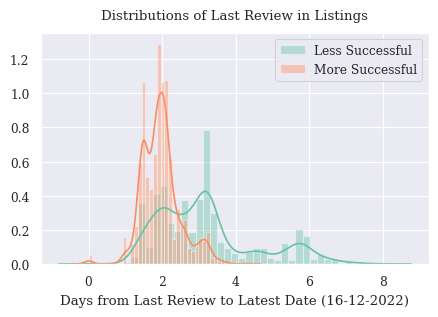

In [185]:
fig, ax = plt.subplots(figsize=(5, 3))

less_sample = master_data[master_data.better_than_average == False].last_review
more_sample = master_data[master_data.better_than_average == True].last_review

sns.distplot(less_sample, 
             ax=ax, label='Less Successful')
sns.distplot(more_sample, 
             ax=ax, label='More Successful')

ax.legend()
ax.set_title("Distributions of Last Review in Listings", pad=10)
ax.set_ylabel("")
ax.set_xlabel("Days from Last Review to Latest Date (16-12-2022)")

fig.savefig('figures/last_review_disctribution_comparison.pdf', 
            dpi=300, format='pdf', bbox_inches='tight', facecolor='white')

In [186]:
sig_level = 0.01

_, double_p = ttest_ind(more_sample, less_sample, equal_var=False)

if np.mean(more_sample) > np.mean(less_sample):
    p_value = double_p / 2

else:
    p_value = 1 - (double_p / 2)

print("p-value for the two-sample one-tailed student's t-test:", p_value)

if p_value > 1 - sig_level:
    print("Hence, we can reject the null hypothesis (that the means are equal).")

else:
    print("Hence, we cannot reject the null hypothesis (that the means are equal)")

p-value for the two-sample one-tailed student's t-test: 1.0
Hence, we can reject the null hypothesis (that the means are equal).


### Big Ol' Pairplot

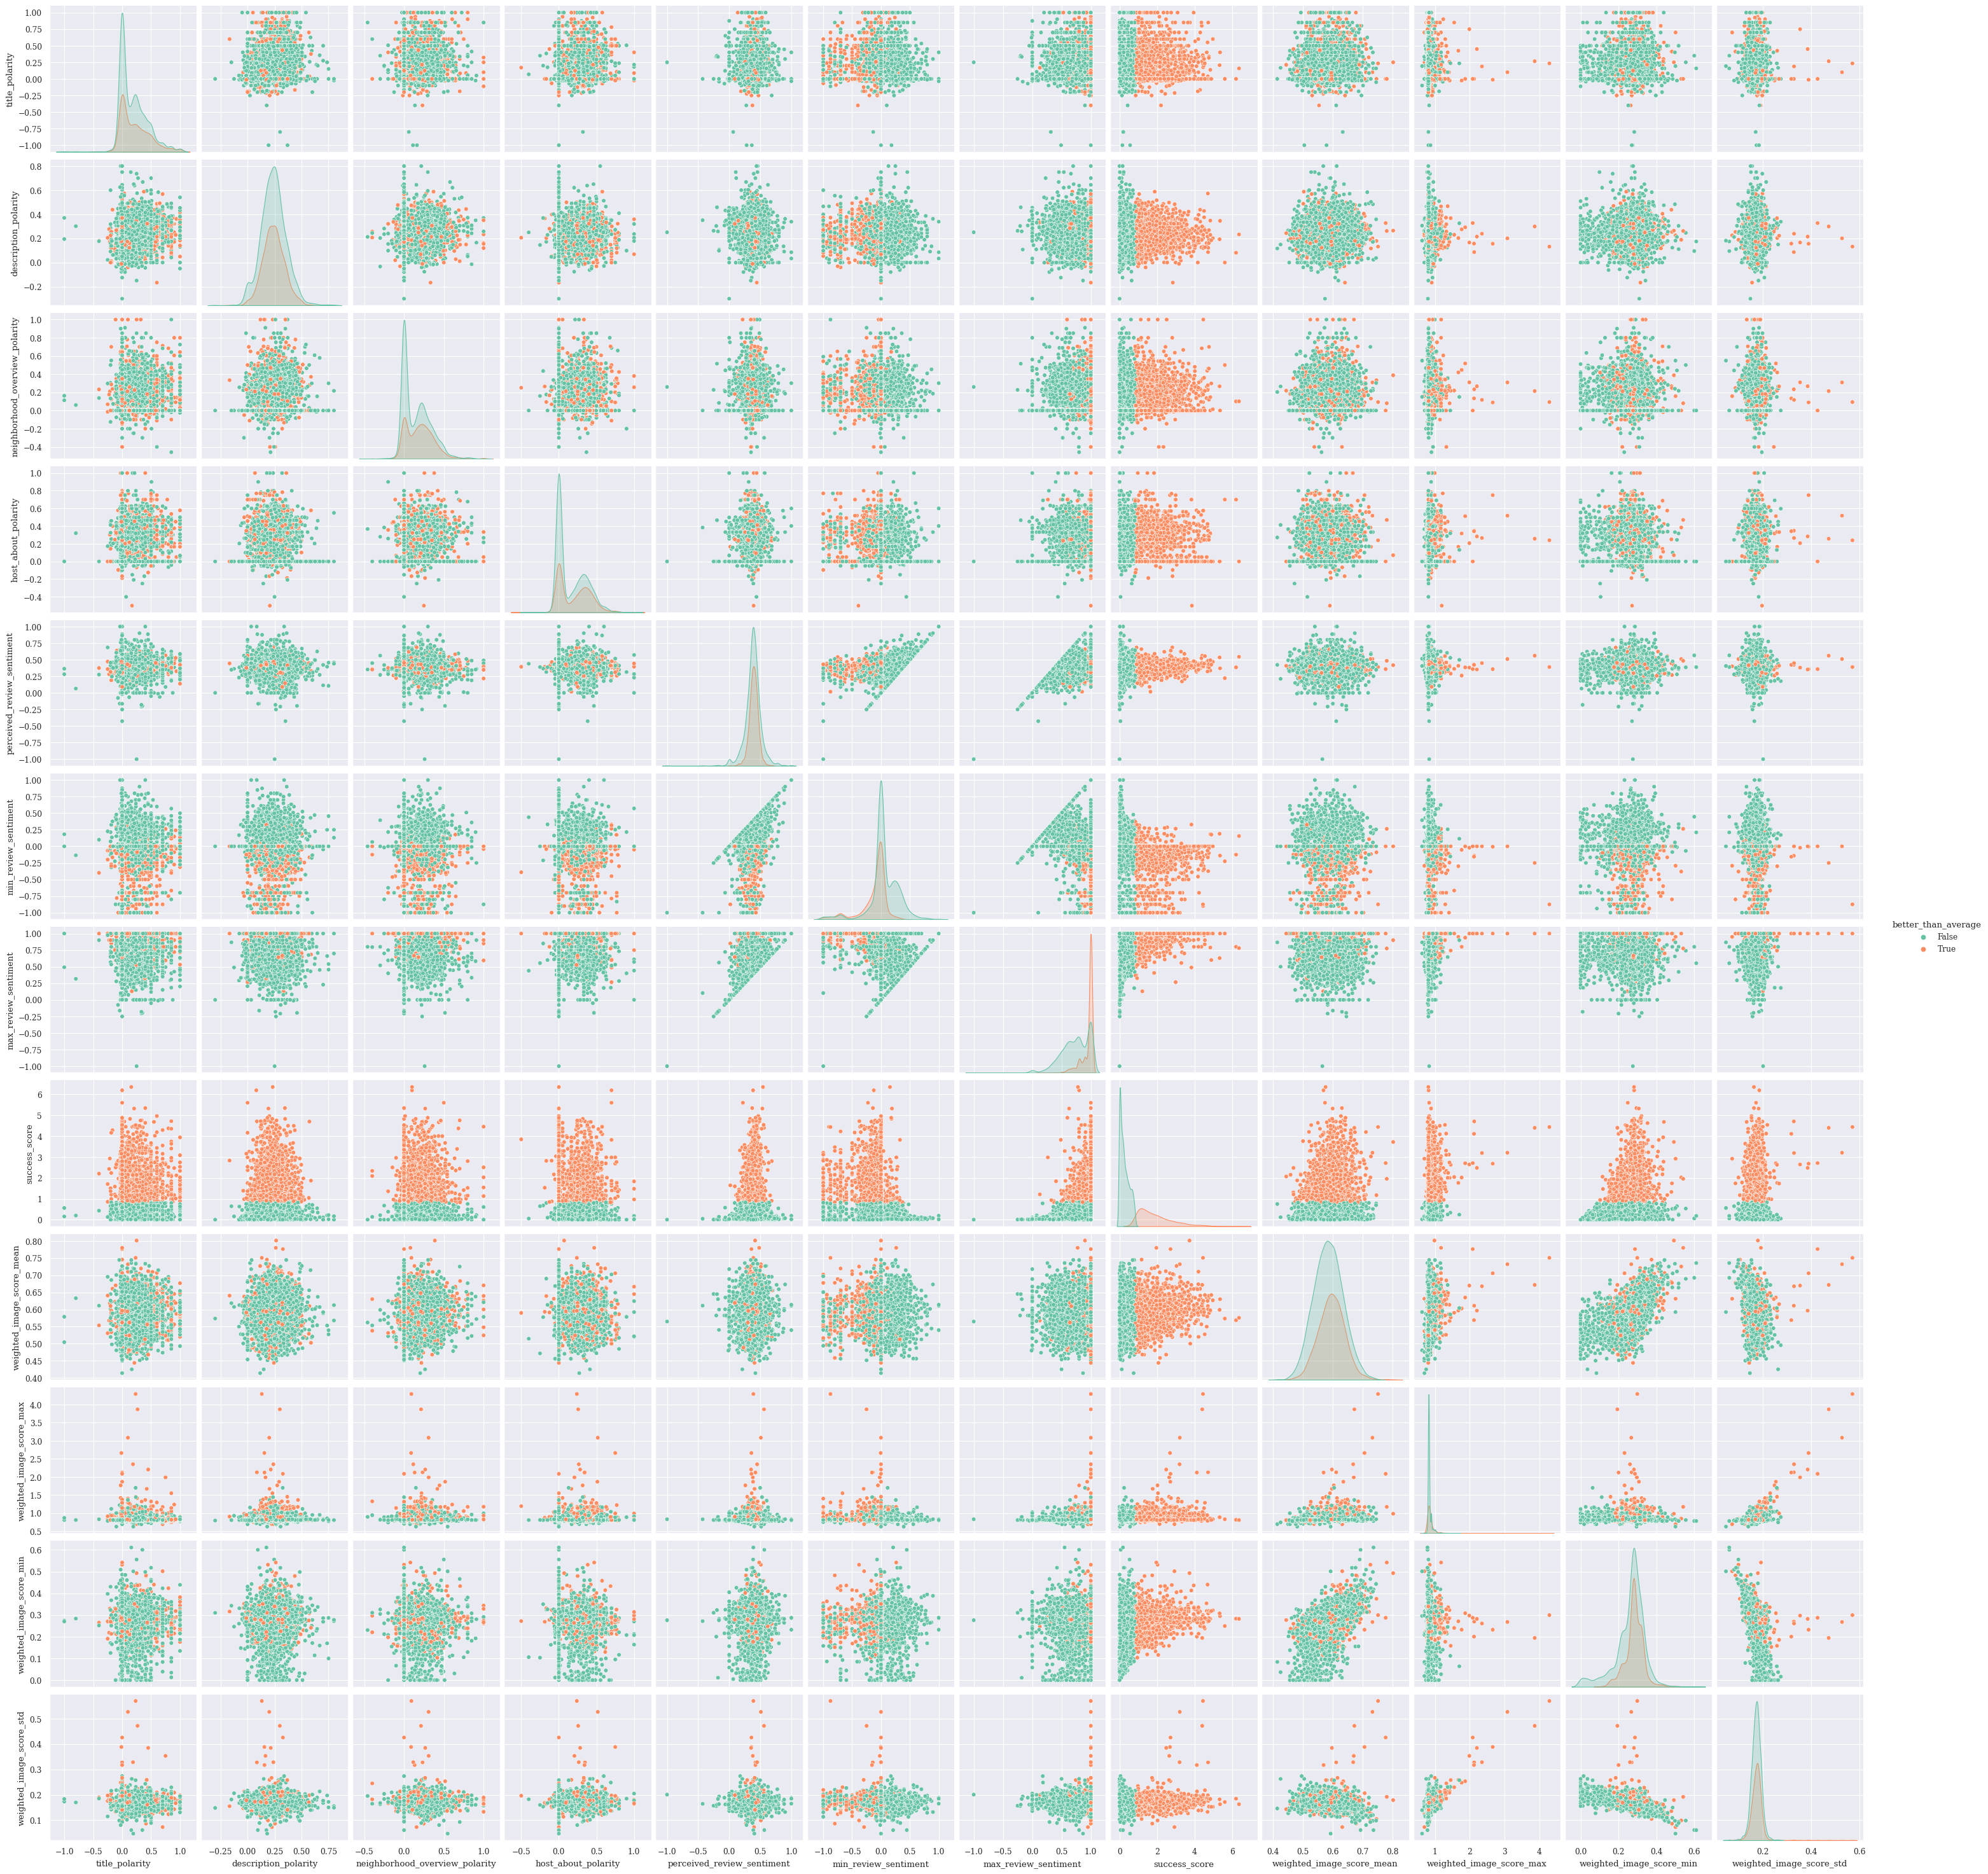

In [187]:
# Pairwise scatterplots (and distributions) of features drawn from unstructured data sources, distinguishing between more and less successful.
data = master_data[[
    'title_polarity', 
    'description_polarity',
    'neighborhood_overview_polarity',
    'host_about_polarity',
    'perceived_review_sentiment',
    'min_review_sentiment', 
    'max_review_sentiment', 
    'success_score', 
    'weighted_image_score_mean',
    'weighted_image_score_max', 
    'weighted_image_score_min',
    'weighted_image_score_std', 
    'better_than_average'
]]

sns.pairplot(data, hue='better_than_average')